# Run and process the prior monte carlo and pick a "truth" realization

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

flopy is installed in /Users/jeremyw/Dev/gw1876/activities_2day_mfm/notebooks/flopy


In [2]:
t_d = "template"
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))

### Decide what pars are uncertain in the truth

We need to decide what our truth looks like - should the pilot points or the grid-scale pars be the source of spatial variability?

In [3]:
par = pst.parameter_data
# grid pars
should_fix = par.loc[par.pargp.apply(lambda x: "gr" in x),"parnme"]
# pp pars
#should_fix = par.loc[par.pargp.apply(lambda x: "pp" in x),"parnme"]
#pst.npar - should_fix.shape[0]

In [4]:
pe = pyemu.ParameterEnsemble.from_binary(pst=pst,filename=os.path.join(t_d,"prior.jcb"))
pe.loc[:,should_fix] = 1.0
pe.to_csv(os.path.join(t_d,"sweep_in.csv"))

new binary format detected...


### run the prior ensemble in parallel locally

In [5]:
m_d = "master_prior_sweep"
pyemu.os_utils.start_slaves(t_d,"pestpp-swp","freyberg.pst",num_slaves=20,slave_root=".",master_dir=m_d)

### Load the output ensemble and plot a few things



In [6]:
obs_df = pd.read_csv(os.path.join(m_d,"sweep_out.csv"),index_col=0)
obs_df.shape

(200, 4445)

drop any failed runs

In [7]:
obs_df = obs_df.loc[obs_df.failed_flag==0,:]
obs_df.shape

(200, 4445)

In [8]:
fnames = pst.pestpp_options["forecasts"].split(',')
fnames

['fa_hw_19791230',
 'fa_hw_19801229',
 'fa_tw_19791230',
 'fa_tw_19801229',
 'hds_00_015_002_000',
 'hds_00_015_002_001']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1825e80c88>,
      dtype=object)

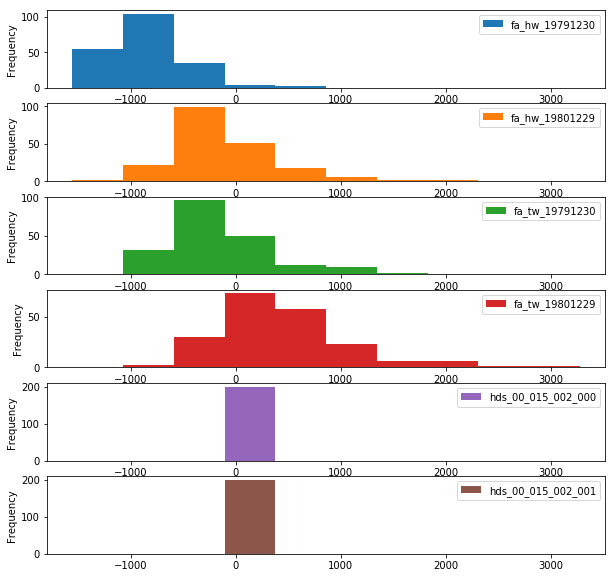

In [9]:
obs_df.loc[:,fnames].plot(kind="hist",subplots=True,figsize=(10,10),sharex=False)

We see that under scenario conditions, many more realizations for the flow to the aquifer in the headwaters are postive (as expected).  Lets difference these two:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1106af5f8>,
      dtype=object)

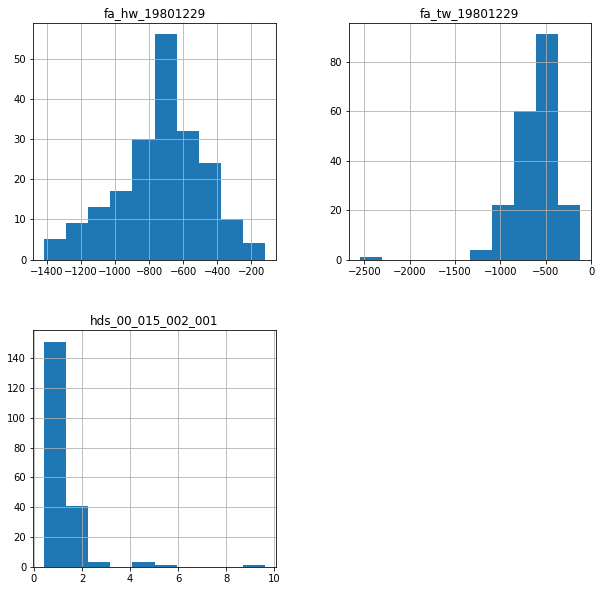

In [10]:
sfnames = [f for f in fnames if "1980" in f or "_001" in f]
hfnames = [f for f in fnames if "1979" in f or "_000" in f]
diff = obs_df.loc[:,hfnames].values - obs_df.loc[:,sfnames].values
diff = pd.DataFrame(diff,columns=sfnames)
diff.hist(figsize=(10,10))

We now see that the most extreme scenario yields a large decrease in flow from the aquifer to the headwaters (the most negative value)

### setting the "truth"

We just need to replace the observed values (`obsval`) in the control file with the outputs for one of the realizations on `obs_df`.  In this way, we now have the nonzero values for history matching, but also the ``truth`` values for comparing how we are doing with other unobserved quantities.  Im going to pick a realization that yields an "average" variability of the observed gw levels:

In [11]:
# choose the realization with a historic gw to sw headwater flux
hist_swgw = obs_df.loc[:,"fa_hw_19791230"].sort_values()
idx = hist_swgw.index[20]

In [12]:
obs_df.loc[idx,pst.nnz_obs_names]

fo_39_19791230        12414.000000
hds_00_002_009_000       35.680511
hds_00_002_015_000       34.862705
hds_00_003_008_000       35.857883
hds_00_009_001_000       37.504265
hds_00_013_010_000       35.166023
hds_00_015_016_000       34.724293
hds_00_021_010_000       35.080688
hds_00_022_015_000       34.435143
hds_00_024_004_000       36.165443
hds_00_026_006_000       35.476448
hds_00_029_015_000       34.340340
hds_00_033_007_000       34.252705
hds_00_034_010_000       34.005688
Name: 59, dtype: float64

Lets see how our selected truth does with the swgw forecasts:

In [13]:
obs_df.loc[idx,fnames]

fa_hw_19791230       -1225.097500
fa_hw_19801229        -581.025400
fa_tw_19791230        -540.718602
fa_tw_19801229         -64.626890
hds_00_015_002_000      37.470177
hds_00_015_002_001      36.588055
Name: 59, dtype: float64

In [14]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
obs = pst.observation_data
obs.loc[:,"obsval"] = obs_df.loc[idx,pst.obs_names]
obs.loc[obs.obgnme=="calhead","weight"] = 10.0
obs.loc["fo_39_19791230","weight"] = 0.025
obs.weight.value_counts()

0.000     4420
10.000      13
0.025        1
Name: weight, dtype: int64

Now, it is custom to add noise to the observed values...we will use the classic Gaussian noise...zero mean and standard deviation of 1 over the weight

In [15]:
# this should give the same standard normal draws each time
np.random.seed(seed=0)
snd = np.random.randn(pst.nnz_obs)
snd

array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
       -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ,
        0.14404357,  1.45427351,  0.76103773,  0.12167502])

In [16]:
noise = snd * 1./obs.loc[pst.nnz_obs_names,"weight"]
noise

obsnme
fo_39_19791230        70.562094
hds_00_002_009_000     0.040016
hds_00_002_015_000     0.097874
hds_00_003_008_000     0.224089
hds_00_009_001_000     0.186756
hds_00_013_010_000    -0.097728
hds_00_015_016_000     0.095009
hds_00_021_010_000    -0.015136
hds_00_022_015_000    -0.010322
hds_00_024_004_000     0.041060
hds_00_026_006_000     0.014404
hds_00_029_015_000     0.145427
hds_00_033_007_000     0.076104
hds_00_034_010_000     0.012168
Name: weight, dtype: float64

Only run this block once!!!

In [17]:
pst.observation_data.loc[noise.index,"obsval"] += noise
pst.write(os.path.join(t_d,"freyberg.pst"))
pyemu.os_utils.run("pestpp-ies freyberg.pst",cwd=t_d)

In [18]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
print(pst.phi)
pst.res.loc[pst.nnz_obs_names,:]

1503.8648947149577


,name,group,measured,modelled,residual,weight
name,,,,,,
fo_39_19791230,fo_39_19791230,calflux,12484.562094,11430.000000,1054.562094,0.025
hds_00_002_009_000,hds_00_002_009_000,calhead,35.720527,37.107498,-1.386971,10.000
hds_00_002_015_000,hds_00_002_015_000,calhead,34.960579,35.045185,-0.084606,10.000
hds_00_003_008_000,hds_00_003_008_000,calhead,36.081973,37.397289,-1.315317,10.000
hds_00_009_001_000,hds_00_009_001_000,calhead,37.691021,39.546417,-1.855397,10.000
hds_00_013_010_000,hds_00_013_010_000,calhead,35.068295,35.571774,-0.503478,10.000
hds_00_015_016_000,hds_00_015_016_000,calhead,34.819302,34.835716,-0.016415,10.000
hds_00_021_010_000,hds_00_021_010_000,calhead,35.065553,35.386250,-0.320697,10.000
hds_00_022_015_000,hds_00_022_015_000,calhead,34.424821,34.577492,-0.152671,10.000


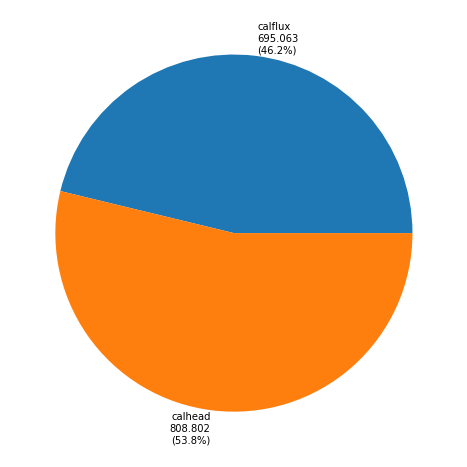

In [19]:
pst.phi_components
pst.plot(kind='phi_pie')

<Figure size 576x756 with 0 Axes>

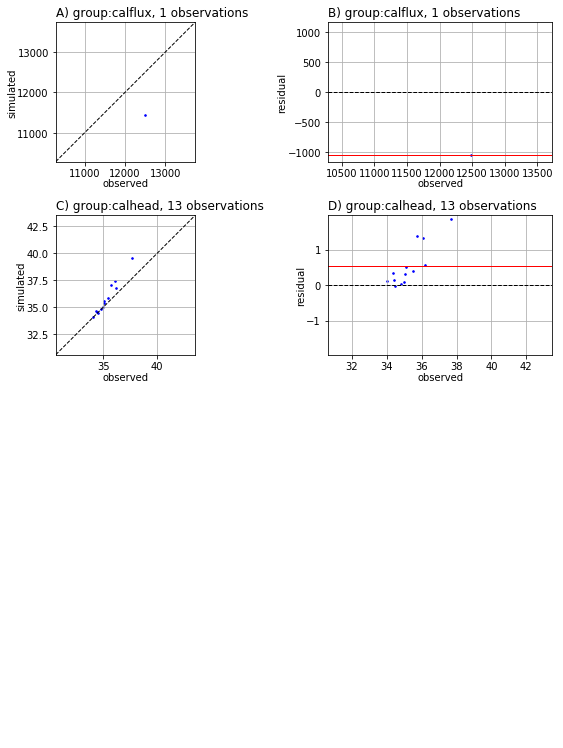

In [20]:
figs = pst.plot(kind="1to1")

Publication ready figs - oh snap!

Just to make sure we have everything working right, we should be able to load the truth parameters, run the model once and have a `phi` equivalent to the noise vector:

In [21]:
par_df = pd.read_csv(os.path.join(m_d,"sweep_in.csv"),index_col=0)
pst.parameter_data.loc[:,"parval1"] = par_df.loc[idx,pst.par_names]
pst.write(os.path.join(m_d,"test.pst"))
pyemu.os_utils.run("pestpp-ies.exe test.pst",cwd=m_d)
pst = pyemu.Pst(os.path.join(m_d,"test.pst"))
print(pst.phi)
pst.res.loc[pst.nnz_obs_names,:]

17.528847237527355


,name,group,measured,modelled,residual,weight
name,,,,,,
fo_39_19791230,fo_39_19791230,calflux,12484.562094,12414.000000,70.562094,0.025
hds_00_002_009_000,hds_00_002_009_000,calhead,35.720527,35.680511,0.040016,10.000
hds_00_002_015_000,hds_00_002_015_000,calhead,34.960579,34.862705,0.097874,10.000
hds_00_003_008_000,hds_00_003_008_000,calhead,36.081973,35.857883,0.224089,10.000
hds_00_009_001_000,hds_00_009_001_000,calhead,37.691021,37.504265,0.186756,10.000
hds_00_013_010_000,hds_00_013_010_000,calhead,35.068295,35.166023,-0.097728,10.000
hds_00_015_016_000,hds_00_015_016_000,calhead,34.819302,34.724293,0.095009,10.000
hds_00_021_010_000,hds_00_021_010_000,calhead,35.065553,35.080688,-0.015136,10.000
hds_00_022_015_000,hds_00_022_015_000,calhead,34.424821,34.435143,-0.010322,10.000


The residual should be exactly the noise values from above.Lets load the model (that was just run using the true pars) and check some things

In [22]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=m_d)

0.01400483 0.5398078


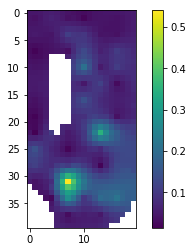

In [23]:
a = m.upw.vka[1].array
#a = m.rch.rech[0].array
a = np.ma.masked_where(m.bas6.ibound[0].array==0,a)
print(a.min(),a.max())
c = plt.imshow(a)
plt.colorbar(c)

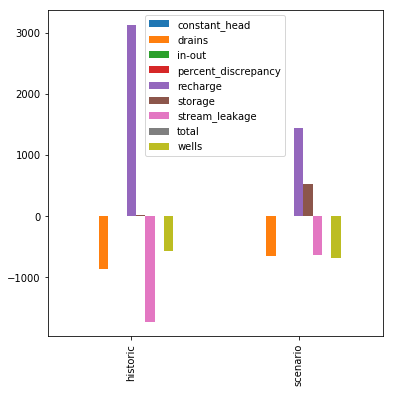

In [24]:
lst = flopy.utils.MfListBudget(os.path.join(m_d,"freyberg.list"))
df = lst.get_dataframes(diff=True)[0]
ax = df.plot(kind="bar",figsize=(6,6))
a = ax.set_xticklabels(["historic","scenario"],rotation=90)

### see how our existing observation ensemble compares to the truth

sw-gw outputs:

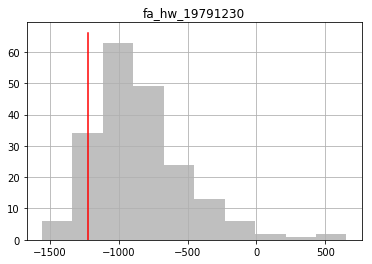

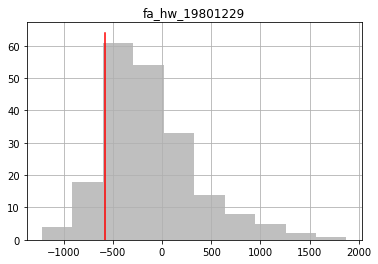

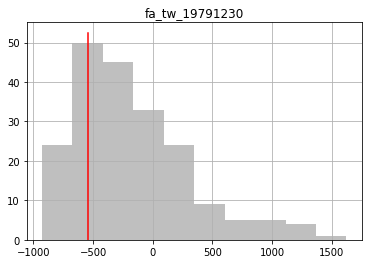

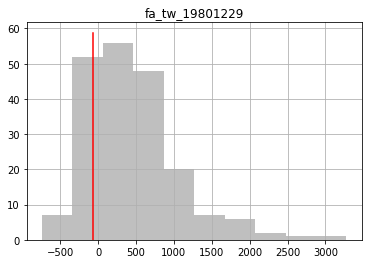

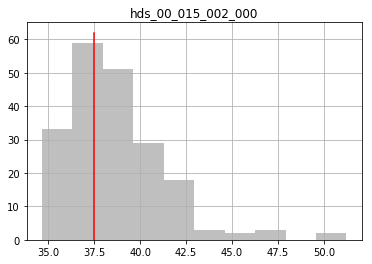

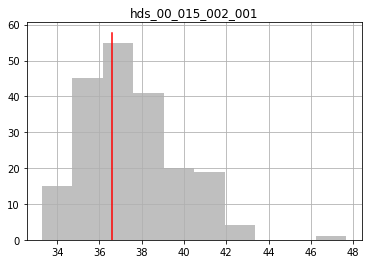

In [25]:
obs = pst.observation_data

for forecast in fnames:
    ax = plt.subplot(111)
    obs_df.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(forecast)
    plt.show()

observations:

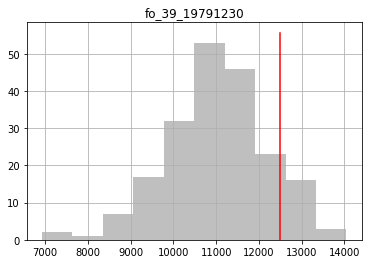

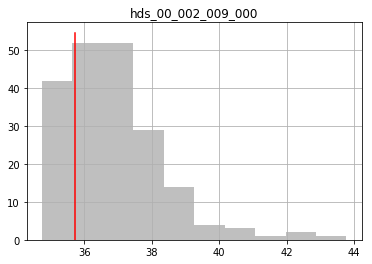

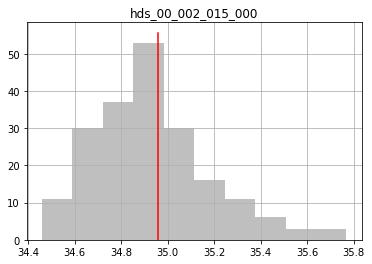

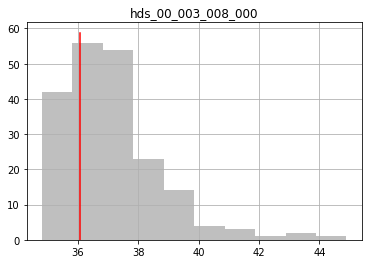

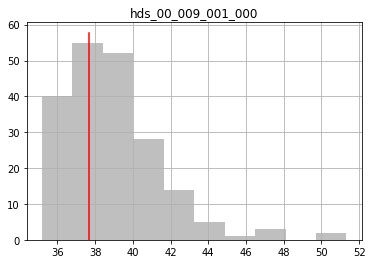

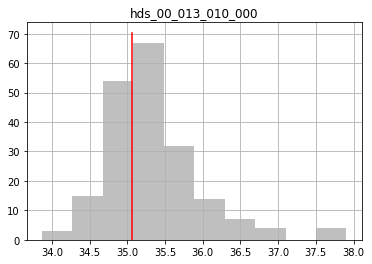

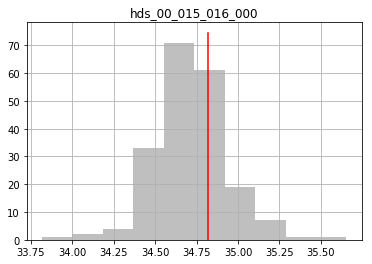

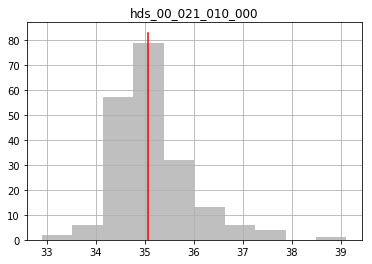

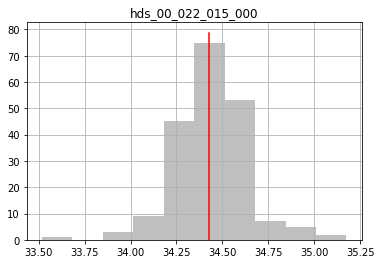

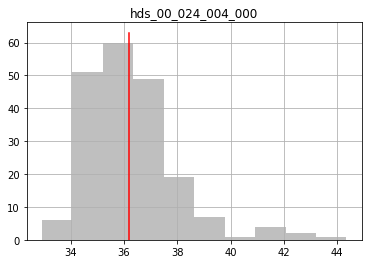

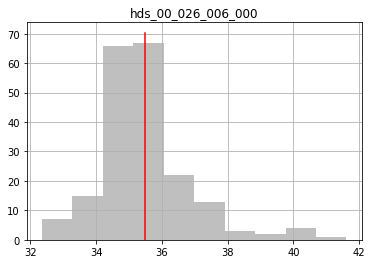

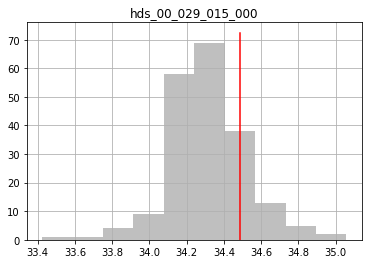

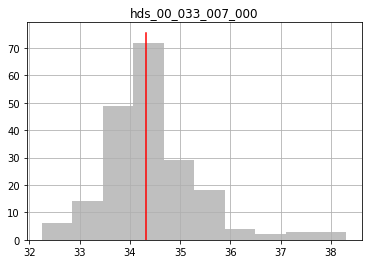

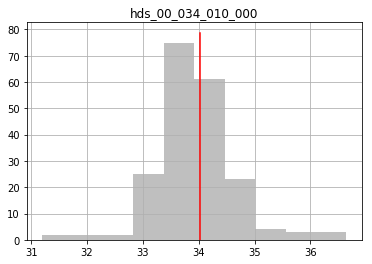

In [26]:
for oname in pst.nnz_obs_names:
    ax = plt.subplot(111)
    obs_df.loc[:,oname].hist(ax=ax,color="0.5",alpha=0.5)
    ax.plot([obs.loc[oname,"obsval"],obs.loc[oname,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(oname)
    plt.show()